In [111]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils import data
import matplotlib.pyplot as plt

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [113]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST("~/.pytorch", transform=transform, download=True)
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

In [114]:
train_data[0][0].size()

torch.Size([1, 28, 28])

In [115]:
@torch.enable_grad()
def update(model, data_loader, loss, opt):
    device = next(model.parameters()).device
    model.train()
    
    errors= []
    for x, _ in data_loader:
        x = x.to(device)
        y_hat, (mu, log_var) = model(x)
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        l = loss(y_hat, x) 
        err = l + kld
        errors.append(err)
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return errors

In [116]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 5),
                                     nn.MaxPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 5),
                                     nn.MaxPool2d(2),
                                     nn.ReLU()
                                    )
        
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 6, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 1, 6, stride=2),
                                     )
    
        self.mu = nn.Sequential(nn.Linear(64*4*4, 128))
        self.sigma = nn.Sequential(nn.Linear(64*4*4, 128))
        self.fc = nn.Sequential(nn.Linear(128, 64*4*4))
    
    
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64*4*4)
        m = self.mu(x)
        s = self.sigma(x)
        return m, s
        
    def decode(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        m, s = self.encode(x)
        z = self.sample(m, s)
        o = self.decode(z)
        return o, (m, s)
    
    def sample(self, mean, log_var):
        std = torch.exp(0.5*log_var).to(device)
        eps = torch.randn_like(std).to(device)
        return mean + std * eps 
 
    @torch.no_grad()
    def generate(self, mean=None, log_var=None):
        if mean is None:
            mean = torch.empty((64, 128)).uniform_(-0.01, 0.01).to(device)
            
        if log_var is None:
            log_var = 0.
            log_var = torch.ones((64, 128)).to(device) * log_var
        
        x = self.sample(mean, log_var)
        x = self.decode(x)
        return torch.sigmoid(x)
    
    @torch.no_grad()
    def reconstruct(self, x):
        m, s = self.encode(x)
        return self.generate(m, s)

In [117]:
model = AutoEncoder().to(device)

In [118]:
n_epochs = 20
lr = 1e-3

criterion = nn.BCEWithLogitsLoss(reduction="sum")
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [119]:
for epoch in range(n_epochs):
    errors = update(model, train_loader, criterion, opt)
    print(f"Error: {sum(errors)/len(errors)}")

Error: 9855.3427734375
Error: 7334.064453125
Error: 6989.8330078125
Error: 6866.16064453125
Error: 6797.99169921875
Error: 6753.89697265625
Error: 6716.4765625
Error: 6686.578125
Error: 6663.99072265625
Error: 6636.798828125
Error: 6620.998046875
Error: 6605.38525390625
Error: 6588.17236328125
Error: 6575.80029296875
Error: 6562.14599609375
Error: 6552.357421875
Error: 6543.0615234375
Error: 6533.775390625
Error: 6521.2529296875
Error: 6516.2255859375


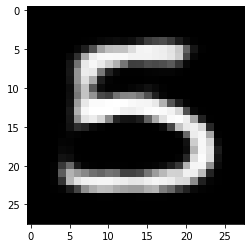

torch.Size([64, 1, 28, 28])


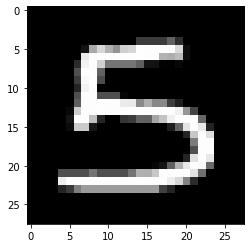

In [122]:
# reconstruct
for x, _ in train_loader:
    x = x.to(device)
    m, s = model.encode(x)
    out = model.generate(m, s)
    out = torch.sigmoid(out)
    break
    
plt.imshow(out[10].view(28, 28).cpu().detach().numpy(), cmap="gray")
plt.show()

print(x.size())
plt.imshow(x[10].view(28, 28).cpu().detach().numpy(), cmap="gray")
plt.show()

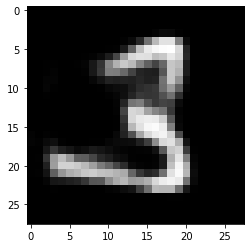

In [129]:
# generate a new digit
samples = model.generate()
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap="gray")
plt.show()